In [135]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from scipy.misc import imread
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.feature import blob_doh
import cv2

%matplotlib inline

In [158]:
IMG_NUM = 1

In [159]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thick)
    # Return the image copy with boxes drawn
    return draw_img

def gaussian_blur(img, kernel_size):
    """
    Applies a Gaussian Noise kernel
    :param img:
    :param kernel_size:
    :return:
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [160]:
img = imread('../test_images/heatmap%s.jpg' % IMG_NUM)[:,:,0]
img_org = imread('../test_images/test%s.jpg' % IMG_NUM)

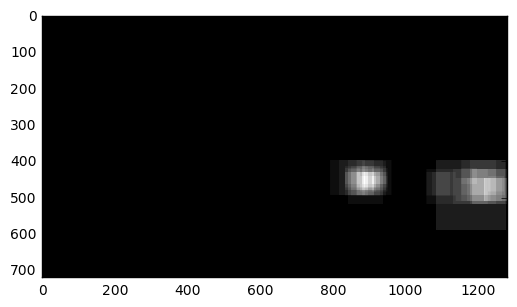

In [161]:
plt.imshow(img, cmap='gray')

# Technique 1: Blob detection 

In [220]:
# Threshold image
# img_thresh = np.zeros(img.shape, dtype=np.uint8)
# img_blur = gaussian_blur(img, 21)
# img_thresh[img_blur > 70] = 255

img_thresh = np.zeros(img.shape, dtype=np.uint8)

#blob detection
blobs = blob_doh(img_thresh, num_sigma=4, min_sigma=1, max_sigma=255, threshold=.01)
#plot result
fig, axis = plt.subplots(1, 3, figsize=(11,6))

[ax.axis('off') for ax in axis]
axis[0].imshow(img, cmap='gray')
axis[1].imshow(img_thresh, cmap='gray')
axis[2].imshow(img_thresh, cmap='gray')
for blob in blobs:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='g', linewidth=2, fill=False)
    axis[2].add_patch(c)

IndexError: index 2 is out of bounds for axis 1 with size 2

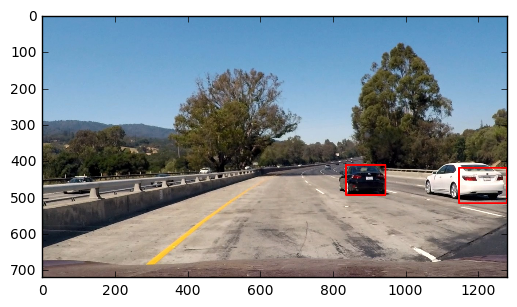

In [214]:
# # Threshold image
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)
img_thresh[img_blur > 70] = 255

#blob detection
blobs = blob_doh(img_thresh, num_sigma=4, min_sigma=1, max_sigma=255, threshold=.01)

boxes = np.zeros((len(blobs), 4), dtype=np.uint32)
for i, blob in enumerate(blobs):
    blob = np.array(blob, dtype=np.uint32)
    blob_area = np.array([blob[1]-blob[2], blob[0]-blob[2], blob[1]+blob[2],  blob[0]+blob[2]])
    sec = img_thresh[blob_area[1]:blob_area[3], blob_area[0]:blob_area[2]]
    filled = sec.nonzero()
    box = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])
    
    box[0, :2] += np.expand_dims(blob_area, axis=0)[0, :2]
    box[0, 2:] += np.expand_dims(blob_area, axis=0)[0, :2]

    boxes[i] = box

img_blob = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
plt.imshow(img_blob, cmap='gray')

# Technique 2: Watershed

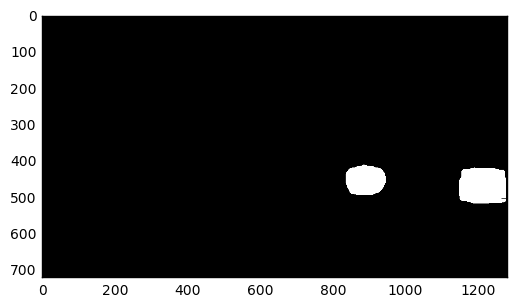

In [164]:
# Threshold image
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)

img_thresh[img_blur > 70] = 255

# caldistance from background
local_maxi = peak_local_max(img_thresh,
                            indices=False,
                            #num_peaks=1,
                            #threshold_abs=.1,
                            footprint=np.ones((10, 10)),
                            labels=np.copy(img_thresh))
plt.imshow(local_maxi, cmap='gray')

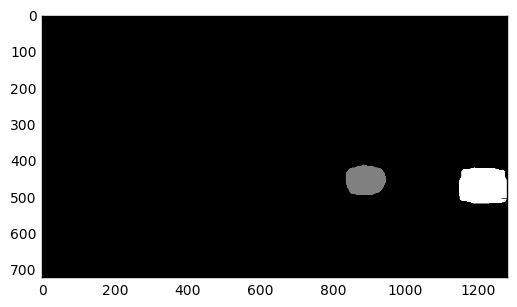

In [165]:
markers = ndi.label(local_maxi)[0]
labels = watershed(-img_thresh, markers, mask=img_thresh)

plt.imshow(labels, cmap='gray')

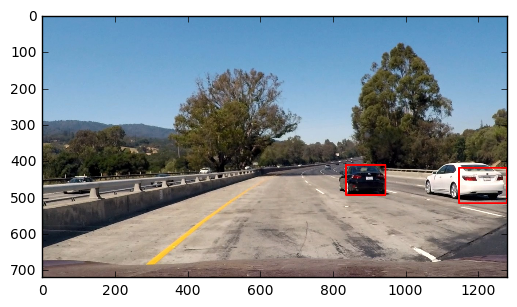

In [215]:
# Threshold image
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)
img_thresh[img_blur > 70] = 255

local_maxi = peak_local_max(img_thresh,
                            indices=False,
                            footprint=np.ones((10, 10)),
                            labels=np.copy(img_thresh))

markers = ndi.label(local_maxi)[0]
labels = watershed(-img_thresh, markers, mask=img_thresh)

boxes = np.zeros((len(np.unique(labels))-1, 4), dtype=np.uint32)
for i, label in enumerate(np.unique(labels)):
    if label == 0:
        continue
    filled = np.where(labels == label)
    boxes[i-1] = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])
    #print(box)

img_watershed = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
plt.imshow(img_watershed, cmap='gray')

# Opencv Bounding Box

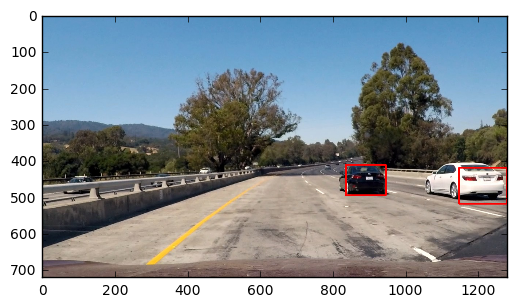

In [216]:
# Threshold image
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)
img_thresh[img_blur > 70] = 255

_, contours, _ = cv2.findContours(img_thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

boxes = np.zeros((len(contours), 4), dtype=np.uint32)
for i, contour in enumerate(contours):
    rectangle = cv2.boundingRect(contour)

    x,y,w,h = rectangle
    boxes[i] = [x, y, x+w, y+h]

img_contour = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
plt.imshow(img_contour, cmap='gray')

# Blob + Watershed

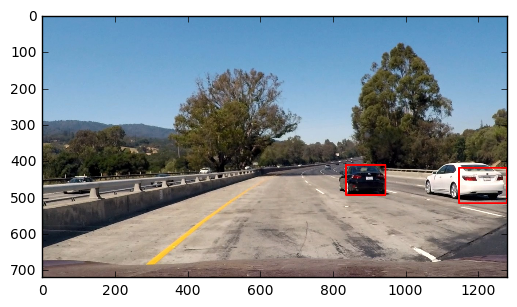

In [218]:
img_thresh = np.zeros(img.shape, dtype=np.uint8)
img_blur = gaussian_blur(img, 21)
img_thresh[img_blur > 70] = 255

blobs = blob_doh(img_thresh, num_sigma=4, min_sigma=1, max_sigma=255, threshold=.01)
blobs = blobs.astype(np.uint32)
centroids = np.zeros(img.shape, dtype=np.bool)
centroids[blobs[:,0], blobs[:,1]] = True
centroids[centroids==True]

markers = ndi.label(centroids)[0]
labels = watershed(-img_thresh, markers, mask=img_thresh)

boxes = np.zeros((len(np.unique(labels))-1, 4), dtype=np.uint32)
for i, label in enumerate(np.unique(labels)):
    if label == 0:
        continue
    filled = np.where(labels == label)
    boxes[i-1] = np.array([[filled[1].min(), filled[0].min(), filled[1].max(), filled[0].max()]])
    #print(box)

img_blob_water = draw_boxes(img_org, boxes, thick=3, color=(255,0,0))
plt.imshow(img_blob_water, cmap='gray')

# Result

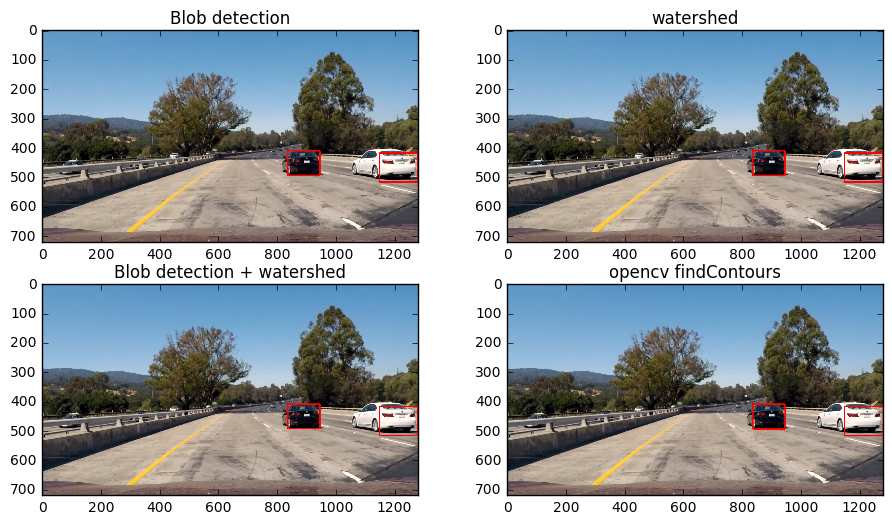

In [219]:
fig, axis = plt.subplots(2,2, figsize=(11,6))
#[col.axis('off') for col in row for row in axis
axis[0,0].imshow(img_blob)
axis[0,0].set_title('Blob detection')
axis[0,1].imshow(img_watershed)
axis[0,1].set_title('watershed')
axis[1,0].imshow(img_blob_water)
axis[1,0].set_title('Blob detection + watershed')
axis[1,1].imshow(img_contour)
axis[1,1].set_title('opencv findContours')